#Video Game Sales with Ratings
*Cas kaggle*

Gerard Benet Martínez - 1704125
Javier Emparan López - 1704634

---

## Definició del problema

Aquest projecte se centra en l'anàlisi predictiva de l'èxit comercial de videojocs, utilitzant una base de dades que integra una àmplia col·lecció de títols amb les seves mètriques de qualitat extretes principalment de la plataforma Metacritic.

- S'analitzaran les dades i s'aplicara els diferents tractaments de preprocesat per adaptar les dades al problema.
- S'entrenaran distints models i es seleccionar el que doni millors resultats.
- El model haura de ser capaç de predir tant ventes globals com per regio (EU, JP, etc)
---



In [52]:
#importacio de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor

import kagglehub




In [53]:

# Importacio de les dades directament de Kaggle
path = kagglehub.dataset_download("rush4ratio/video-game-sales-with-ratings")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Video_Games_Sales_as_at_22_Dec_2016.csv")
print(df)
#inicialitzacio de dades importants
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating', 'Developer','Publisher', 'Genre']

print(len(df['Platform'].unique()))

Using Colab cache for faster access to the 'video-game-sales-with-ratings' dataset.
Path to dataset files: /kaggle/input/video-game-sales-with-ratings
                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA    

## Visualització de les dades
En aquesta primera part fem una visualització inicial de les dades per a tenir una millor comprensió del problema i saber com afrontar-lo apropiadament.

In [54]:
#Funcions de visualització de dades
#Mostrar quantitat de NaNs
def mostrarGraficNaNs(dades):
  nan_counts_all = dades.isnull().sum()

  if not nan_counts_all.empty:
      plt.figure(figsize=(12, 6))

      nan_counts_all.plot(kind='bar', color='darkorange')

      plt.title('Quantitat de missing Values (NaN) per atribut', fontsize=16)
      plt.xlabel('Atributs', fontsize=12)
      plt.ylabel('Quantitat de NaNs', fontsize=12)

      for i, v in enumerate(nan_counts_all):
          plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y', linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


In [55]:
print("Nombre d'atributs:", len(df.columns))
print(df.describe())
print(df.info())

Nombre d'atributs: 16
       Year_of_Release      NA_Sales      EU_Sales      JP_Sales  \
count     16450.000000  16719.000000  16719.000000  16719.000000   
mean       2006.487356      0.263330      0.145025      0.077602   
std           5.878995      0.813514      0.503283      0.308818   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2020.000000     41.360000     28.960000     10.220000   

        Other_Sales  Global_Sales  Critic_Score  Critic_Count    User_Count  
count  16719.000000  16719.000000   8137.000000   8137.000000   7590.000000  
mean       0.047332      0.533543     68.967679     26.360821    162.229908  
std        0.186710      1.547935     13.938165     18.980495    561.282326  
min        0.000000      0.010000     13.000000      

Per una part, podem veure que hi ha tant dades categoriques com dades no categoriques.
- Per la part de dades categoriques estan la plataforma on s'ha publicat el joc (platform), el genere del joc, el publisher, la desenvolupadora i el rating. També podem veure que el user_score no surt com a numeric, pero per que hi ha valors "tbd", els cuals haurem de tractar mes endavant.

- Per la part de dades no categoriques trobem l'any de publicació del joc, les ventes tant en NA, EU, JP, globals i altres, els tipus de valoració que hi ha, tant per la part de critics com d'usuari.

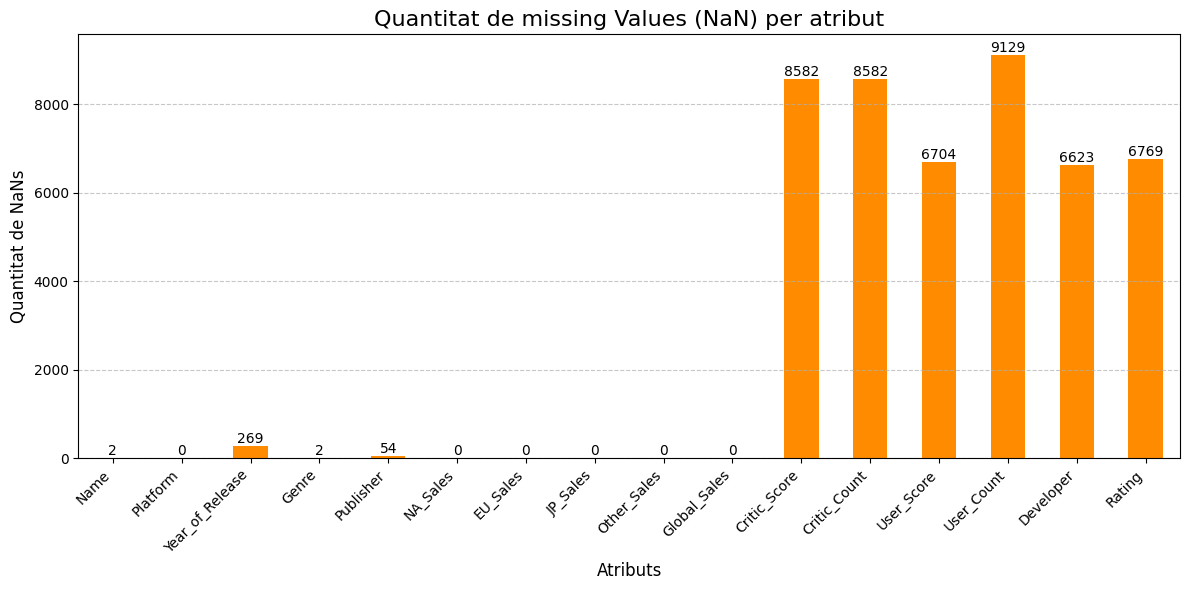

In [56]:
mostrarGraficNaNs(df)

Podem destacar que hi ha una gran quantitat de NaNs en les categories de valoracions (critic/user score i critic/user count), a més de la categoria Developer i rating. També podem veure una petita quantitat de NaNs en l'any de publicació i el publisher del joc.

Per la gran quantita de NaNs que hi ha, no podem optar a eliminar-los completament, ja que aixó reduiria la quantitat de dades drasticament, per tant, optarem per omplir-los.


---
## Preprocessament de dades


---
### Tractament de NaNs

Per una part, com hem vist a la part de visualització de dades, la columna "User_Score" es considerada categorica ja que conté dades "to be determined". Aquestes dades les tractarem com NaNs per poder tractarles mes endavant correctament amb la resta de missing values.

Una vegada tractats els "tbd" podem veure que la puntuació i la cuantitat de valoracions de user/crits encaixen.

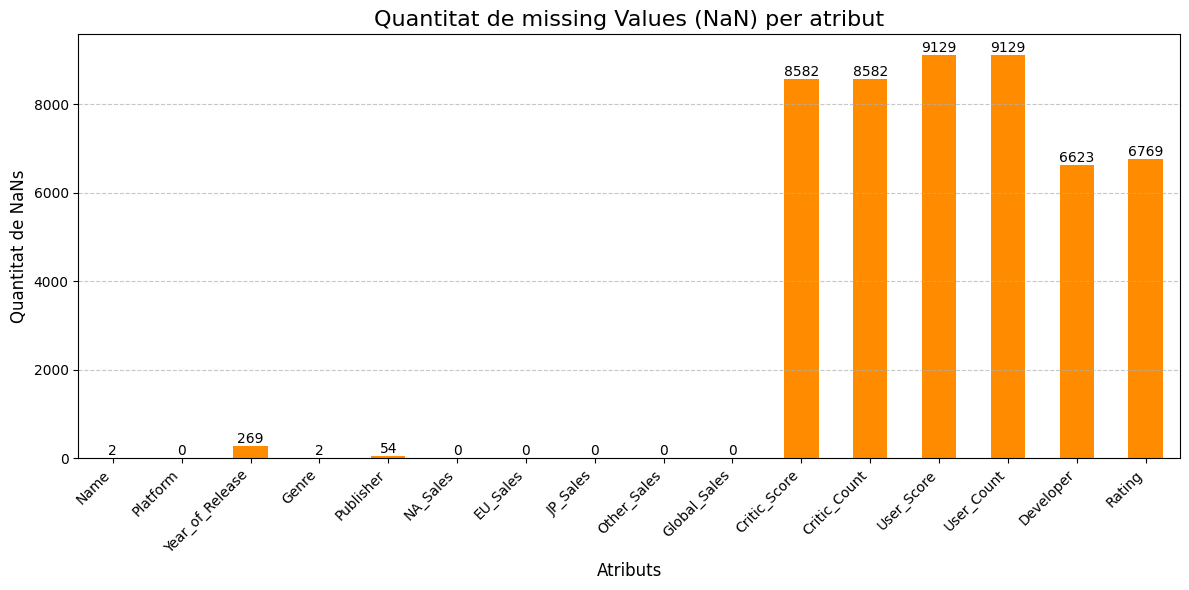

In [57]:
df['User_Score'] = df['User_Score'].replace('tbd', np.nan) #En la columna user score hay tbd. Esto transforma esos en NaNs
df['User_Score'] = pd.to_numeric(df['User_Score']) #Pasarlo a float64
df_fixed = df
mostrarGraficNaNs(df_fixed)


Una vegada fet aixó, podem començar a procesar els NaNs. Hem decidit utilitzar un SimplerImputer, on per omplir els valors numerics utilitzarem  la mediana i per les categoriques utilitzarem la moda.



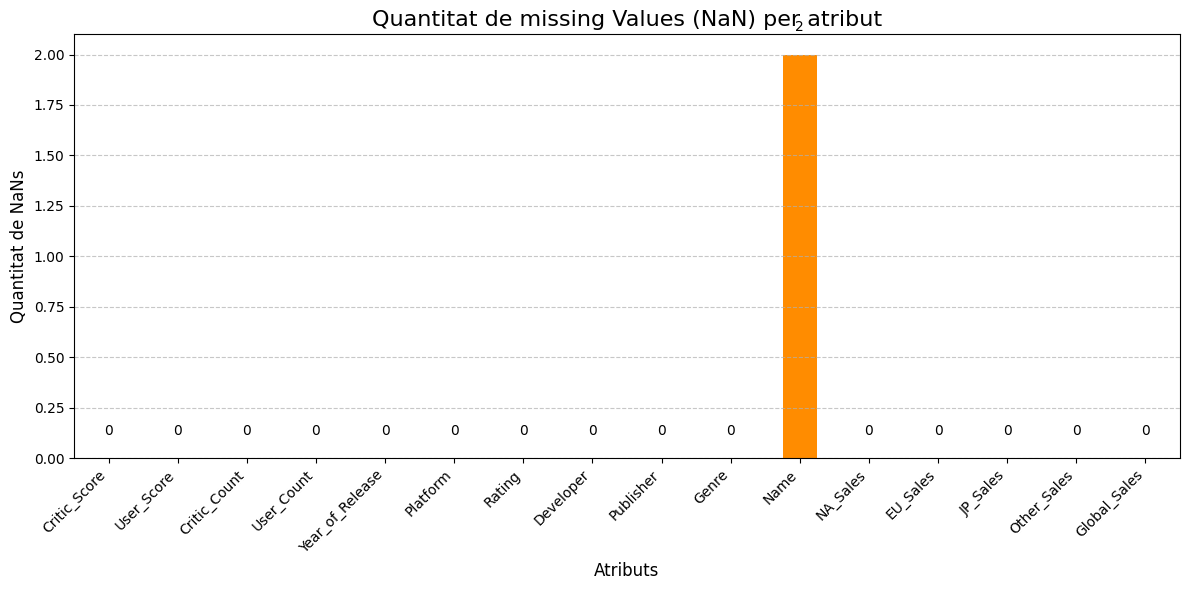

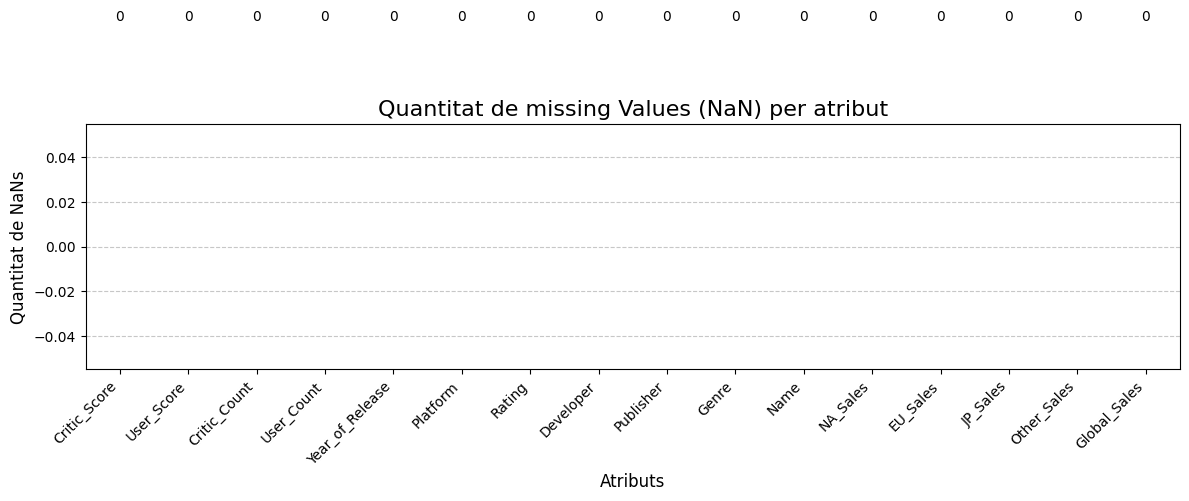

In [58]:
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating', 'Developer','Publisher', 'Genre']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


df_pre_imputed = preprocessor.fit_transform(df_fixed)

columnas_procesadas = numeric_features + categorical_features
columnas_passthrough = [col for col in df_fixed.columns if col not in columnas_procesadas]
columnas_resultado_completo = numeric_features + categorical_features + columnas_passthrough

df_imputed = pd.DataFrame(
    df_pre_imputed,
    columns=columnas_resultado_completo,
    index=df_fixed.index
)

mostrarGraficNaNs(df_imputed)

df_imputed = df_imputed.dropna()

mostrarGraficNaNs(df_imputed)


---
### Data scaling

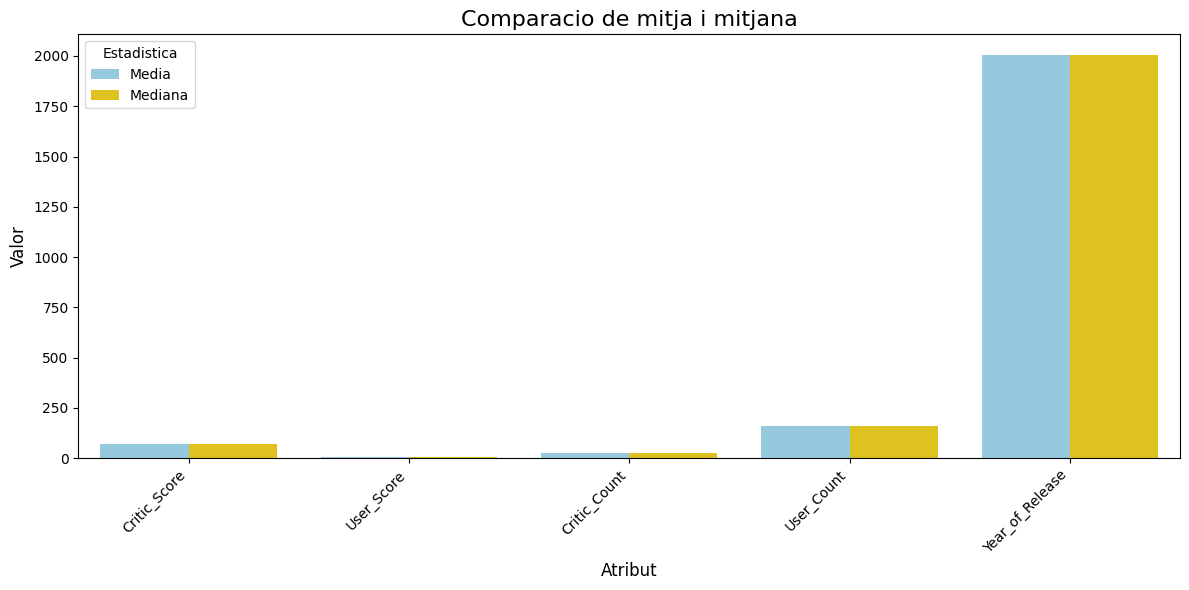

In [59]:
atributosNumericos = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count','Year_of_Release']

df_numeric_data = df_imputed[atributosNumericos]
df2 = df_imputed[atributosNumericos]
atributos_numericos = numeric_features
# -----------------------------------------------------
medias = df2[atributosNumericos].mean().rename('Media')
medianas = df2[atributosNumericos].median().rename('Mediana')

df_stats = pd.concat([medias, medianas], axis=1)

df_plot = df_stats.reset_index().melt(
    id_vars='index',
    var_name='Estadística',
    value_name='Valor'
)

df_plot = df_plot.rename(columns={'index': 'Atributo'})

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Atributo',
    y='Valor',
    hue='Estadística',
    data=df_plot,
    palette={'Media': 'skyblue', 'Mediana': 'gold'}
)
plt.title('Comparacio de mitja i mitjana', fontsize=16)
plt.xlabel('Atribut', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadistica')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Per evitar el biaix de caracteristiques i millorar la convergencia mes endavant quan començem a entrenar els models, probarem diferents scalers. (explicar)

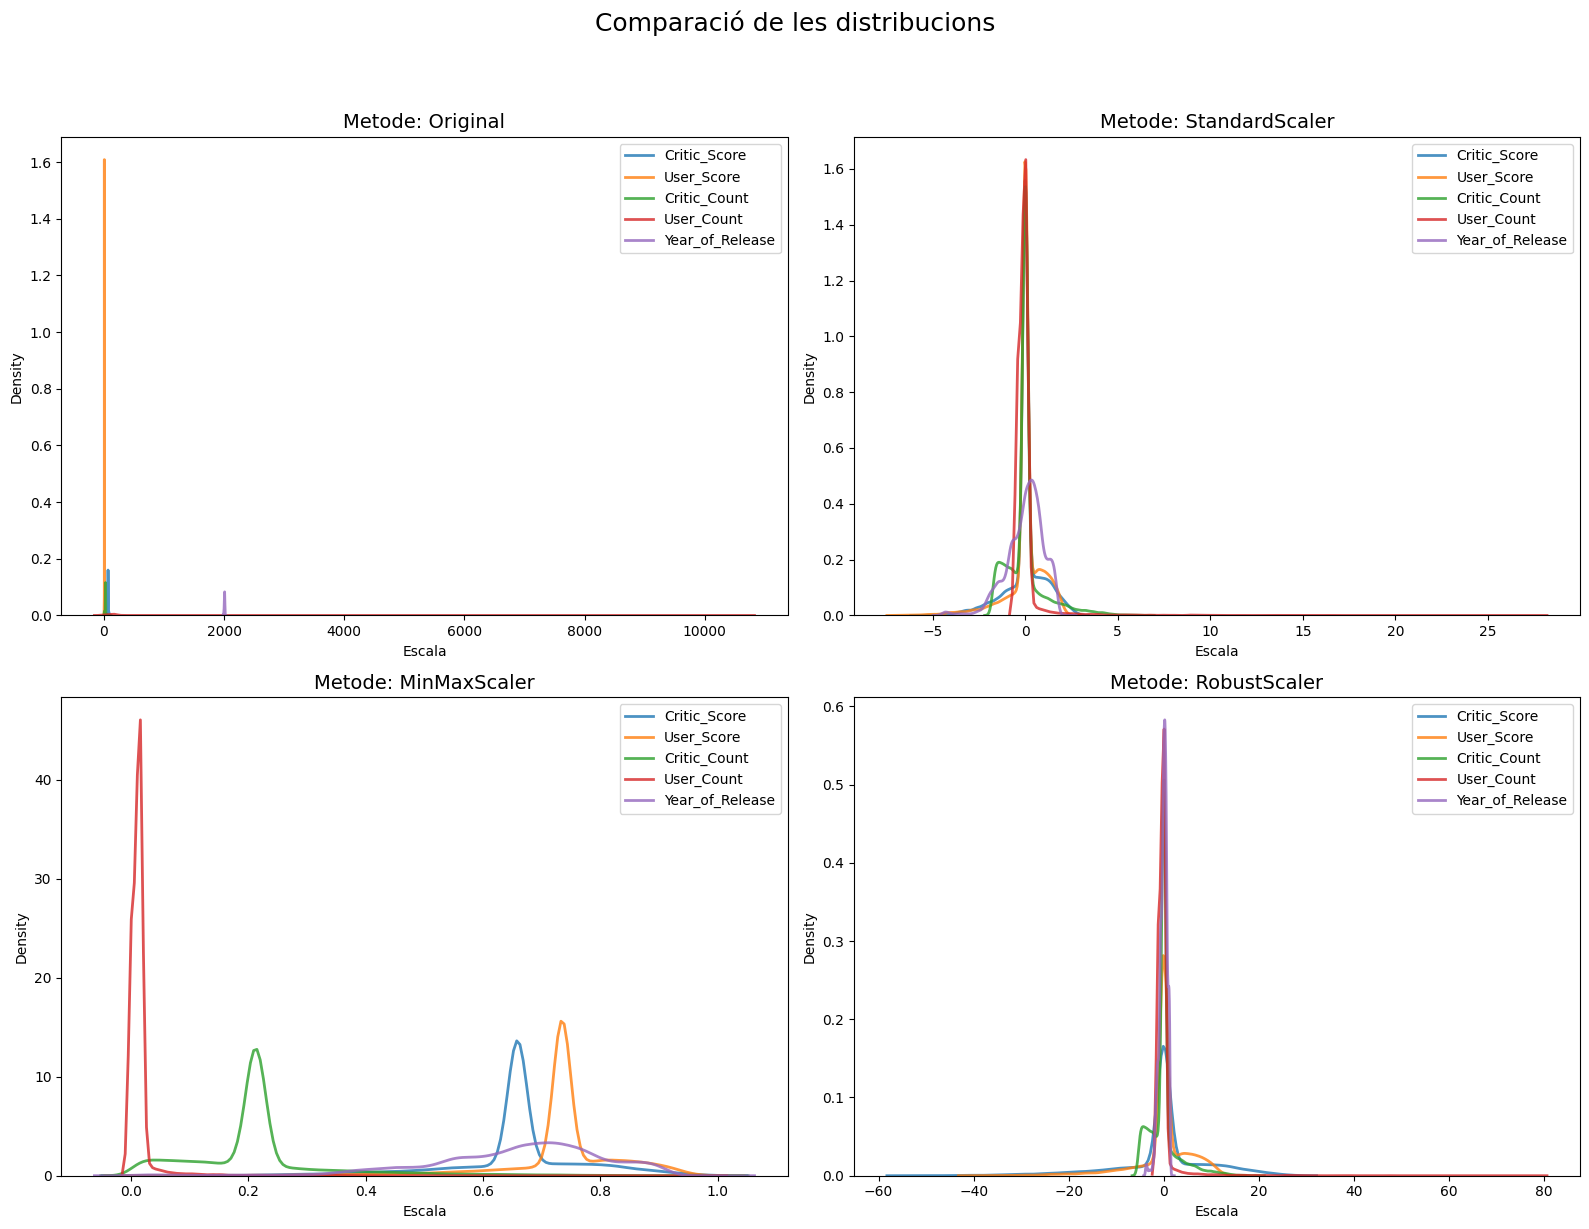

In [60]:
df_numeric_data = df_imputed[numeric_features]

scalers = {
    "Original": df_numeric_data.copy(),
    "StandardScaler": pd.DataFrame(StandardScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "MinMaxScaler": pd.DataFrame(MinMaxScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "RobustScaler": pd.DataFrame(RobustScaler().fit_transform(df_numeric_data), columns=numeric_features)}

plot_cols = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']

plt.figure(figsize=(16, 12))
plt.suptitle('Comparació de les distribucions', fontsize=18, y=1.02)

for i, (name, scaled) in enumerate(scalers.items(), 1):
    plt.subplot(2, 2, i)
    for col in plot_cols:
         sns.kdeplot(scaled[col], fill=False, label=col, alpha=0.8, linewidth=2)

    plt.title(f'Metode: {name}', fontsize=14)
    plt.xlabel('Escala')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

df_scaled = df_imputed.copy()
df_scaled.update(scalers["RobustScaler"])



---
### Tractament de dades categóriques


Per altra banda, també hem de tractar els atributs categorics previament mencionats.

Si mirem la quantitat de valors unics per cada atribut (Platform, Rating, Developer, etc), podem veure que en developer y publisher hi ha una gran quantitat de valors unics. Codificar aquests amb un label/ordinal/onehot encoder pot donar problemes. Per solventar aixó, hem decidit tenir en compte els publishers. Amb aquests, els hem agrupat en 3 grups depenent del nombre de jocs que han publicat.
Per altra hem codificat el rating amb un ordinal encoder, de jocs per petits fins a nomes adults.
Per ultim, hem decidit aplicar onehot encoder al genere del joc.

In [61]:
columnas_categoricas = categorical_features

# 2. Iterar sobre las columnas y mostrar los valores únicos
for columna in columnas_categoricas:
    # Usamos .unique() para obtener la lista de valores únicos
    valores_unicos = df_scaled[columna].unique()

    # Imprimir el resultado
    print(f"\nAtribut: {columna}")
    print(f"Nombre de valors unics: {len(valores_unicos)}")
    # Se imprime solo una muestra para evitar listas muy largas
    print(f"Valors unics: {valores_unicos[:10]}")

    # Si la columna tiene muchos valores únicos, es mejor solo mostrar el conteo
    if len(valores_unicos) > 20:
        print(f"Hi ha mes de 20!")


Atribut: Platform
Nombre de valors unics: 31
Valors unics: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4']
Hi ha mes de 20!

Atribut: Rating
Nombre de valors unics: 8
Valors unics: ['E' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']

Atribut: Developer
Nombre de valors unics: 1696
Valors unics: ['Nintendo' 'Ubisoft' 'Good Science Studio' 'Rockstar North'
 'Polyphony Digital' 'Infinity Ward, Sledgehammer Games' 'Treyarch'
 'Infinity Ward' 'DMA Design' 'Game Arts']
Hi ha mes de 20!

Atribut: Publisher
Nombre de valors unics: 581
Valors unics: ['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'Sega' 'SquareSoft']
Hi ha mes de 20!

Atribut: Genre
Nombre de valors unics: 12
Valors unics: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting']


In [62]:
publisher_counts = df_scaled.groupby('Publisher')['Name'].transform('count')

def classify_by_count(count):
    if count >= 1000:
        return 'Gegant'
    elif count >= 600:
        return 'Gran'
    elif count >= 300:
        return 'Mitja'
    elif count >= 50:
        return 'Petit'
    else:
        return 'Molt petit'

# 3. Aplicar la clasificación y crear la nueva característica segura
df_scaled['Publisher_Tier_Safe'] = publisher_counts.apply(classify_by_count)


# --- Resultados ---
print("Exemple de les primeres files:")
print(df_scaled[['Publisher', 'Publisher_Tier_Safe']].head(5))
print("\nQuantitat de Publishers per Tier:")
print(df_scaled['Publisher_Tier_Safe'].value_counts())
print("-" * 60)

Exemple de les primeres files:
  Publisher Publisher_Tier_Safe
0  Nintendo                Gran
1  Nintendo                Gran
2  Nintendo                Gran
3  Nintendo                Gran
4  Nintendo                Gran

Quantitat de Publishers per Tier:
Publisher_Tier_Safe
Gran          6437
Petit         3968
Molt petit    3379
Mitja         1523
Gegant        1410
Name: count, dtype: int64
------------------------------------------------------------


In [63]:
#ORDINAL ENCODER
rating_categories = [
    ['RP', 'EC', 'K-A', 'E', 'E10+', 'T', 'M', 'AO']
]
ordinal_encoder = OrdinalEncoder(categories=rating_categories)
rating_column = df_scaled[['Rating']]
rating_encoded_array = ordinal_encoder.fit_transform(rating_column)
df_scaled['Rating_Encoded'] = rating_encoded_array.flatten()
df_scaled.drop('Rating', axis=1, inplace=True)


cols_to_encode = ['Genre', 'Platform']
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency = 0.04)
encoded_array = onehot_encoder.fit_transform(df_scaled[cols_to_encode])
new_cols = onehot_encoder.get_feature_names_out(cols_to_encode)
df_encoded = pd.DataFrame(
    encoded_array,
    columns=new_cols,
    index=df_scaled.index
)
df_scaled = pd.concat([df_scaled.drop(cols_to_encode, axis=1), df_encoded], axis=1)

print(df_scaled.columns)


Index(['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count',
       'Year_of_Release', 'Developer', 'Publisher', 'Name', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Publisher_Tier_Safe', 'Rating_Encoded', 'Genre_Action',
       'Genre_Adventure', 'Genre_Fighting', 'Genre_Misc', 'Genre_Platform',
       'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy',
       'Genre_infrequent_sklearn', 'Platform_DS', 'Platform_GBA',
       'Platform_PC', 'Platform_PS', 'Platform_PS2', 'Platform_PS3',
       'Platform_PSP', 'Platform_Wii', 'Platform_X360', 'Platform_XB',
       'Platform_infrequent_sklearn'],
      dtype='object')


---
## Selecció de mètriques
Una vegada preprocesades les dades, seleccionem la millor mètrica pel problema

MSE, RMSE,R^2

Errores grandes son catastróficos,RMSE,Penaliza fuertemente los outliers o grandes desviaciones debido al término cuadrático.

Todos los errores son iguales,MAE,Trata todas las desviaciones por igual; es la más fácil de explicar a personas sin conocimientos técnicos.

Necesitas un resumen del ajuste,R2,Te da el contexto de qué tan útil es tu modelo en comparación con un modelo base simple (la media).

---
## Selecció del model
Una vegada seleccionada la millor mètrica, seleccionarem el millor model pel problema

In [64]:
#Funcions utils adaptades a l'api de sklearn, ja q els utilitzem en el pipelining

numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
rating_feature = ['Rating']
rating_categories = [['RP', 'EC', 'K-A', 'E', 'E10+', 'T', 'M', 'AO']]
genre_platform_features = ['Genre', 'Platform']
publisher_feature = ['Publisher_Tier']
tier_categories = [['Molt petit', 'Petit', 'Mitja', 'Gran', 'Gegant']]

class UserScoreCleaner(BaseEstimator, TransformerMixin): #canvia esl tbd per nans a la columna user score i o pasa a float
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['User_Score'] = X['User_Score'].replace('tbd', np.nan)
        X['User_Score'] = pd.to_numeric(X['User_Score'])
        return X

class PublisherBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Learn publisher counts from the training data
        self.publisher_counts_ = X['Publisher'].value_counts()
        return self

    def transform(self, X):
        X = X.copy()

        def classify_by_count(count_value):
            if count_value >= 1000:
                return 'Gegant'
            elif count_value >= 600:
                return 'Gran'
            elif count_value >= 300:
                return 'Mitja'
            elif count_value >= 50:
                return 'Petit'
            else:
                return 'Molt petit'

        # Map the Publisher column in X to its count using the learned counts
        # Use fillna(0) for publishers that might not have been in the training set
        game_publisher_counts = X['Publisher'].map(self.publisher_counts_).fillna(0)

        # Explicitly ensure the series is numeric before applying the function
        game_publisher_counts = pd.to_numeric(game_publisher_counts, errors='coerce').fillna(0)

        # Apply the classification function to these numerical counts
        X['Publisher_Tier'] = game_publisher_counts.apply(classify_by_count)

        # Drop original columns no longer needed for the model
        cols_to_drop = [c for c in ['Name', 'Developer', 'Publisher'] if c in X.columns]
        X = X.drop(columns=cols_to_drop)
        return X


In [65]:
def construir_preprocesador():
    """Define y ensambla todos los pasos de preprocesamiento en un solo Pipeline."""

    # 1. Numérico: Imputar media + Indicador de Faltantes -> RobustScaler
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())
    ])

    # 2. Rating: Imputar moda -> OrdinalEncoder
    rating_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=rating_categories, handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    # 3. Genre: Imputar moda -> OneHotEncoder
    genre_platform_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # <-- Canvi Clau
    ])

    # 4. Publisher Tier: Imputar moda -> OrdinalEncoder
    publisher_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=tier_categories))
    ])

    # --- Unir todo en el ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('rating', rating_transformer, rating_feature),
            ('genre_platform', genre_platform_transformer, genre_platform_features),
            ('tier', publisher_transformer, publisher_feature)
        ],
        remainder='drop'
    )

    # --- Pipeline de Preprocesamiento Final ---
    full_preprocessor_pipeline = Pipeline(steps=[
        ('cleaner', UserScoreCleaner()),
        ('binner', PublisherBinner()),
        ('preprocessor', preprocessor)
    ])

    return full_preprocessor_pipeline

In [66]:
def entrenar_modelos_lineales(df, target_col, modelo_lineal_tipo='elasticnet'):
    """
    Ejecuta GridSearchCV para modelos lineales usando transformación LOGARÍTMICA
    en el target (y) y genera gráficos de evaluación en la escala real.
    """
    print(f"--- Iniciando GridSearch ({modelo_lineal_tipo.upper()} - LOG SCALE) para: {target_col} ---")

    # 1. Preparar datos
    sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
    # Aseguramos que solo borramos las que existen en el df
    cols_to_drop = [c for c in sales_cols if c in df.columns]
    X = df.drop(columns=cols_to_drop)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Obtener el Preprocesador Completo (Asumido que la función existe en tu entorno)
    preprocessor_pipeline = construir_preprocesador()

    # 3. Configurar el Modelo Base (ElasticNet por defecto) y el Wrapper Logarítmico
    if modelo_lineal_tipo == 'linear':
        internal_model = LinearRegression()
        param_grid = {'regressor__regressor__fit_intercept': [True]}

    else: # Por defecto usamos ElasticNet (que engloba la lógica de Ridge y Lasso)
        # ElasticNet necesita más iteraciones a veces para converger
        internal_model = ElasticNet(random_state=42, max_iter=5000)

        # Grid de hiperparámetros para ElasticNet
        # alpha: cuánto regulariza (0 es OLS, alto es mucha penalización)
        # l1_ratio: 1 es Lasso, 0 es Ridge, 0.5 es mitad y mitad.
        param_grid = {
            'regressor__regressor__alpha': [0.01, 0.1, 1.0, 10.0],
            'regressor__regressor__l1_ratio': [0.1, 0.5, 0.9, 0.99]
        }

    # Envolvemos el modelo para que entrene con log(1+y) y prediga con exp(y)-1
    # Esto maneja la transformación automáticamente.
    model_wrapper = TransformedTargetRegressor(
        regressor=internal_model,
        func=np.log1p,   # Transformación de entrada
        inverse_func=np.expm1 # Transformación de salida (inversa)
    )

    # 4. Pipeline Final
    # Nota: 'regressor' aquí se refiere al TransformedTargetRegressor
    full_pipeline = Pipeline(steps=[
        ('preproc', preprocessor_pipeline),
        ('regressor', model_wrapper)
    ])

    # 5. Configurar y Ejecutar GridSearchCV
    # Nota: R2 se calculará sobre las predicciones YA INVERTIDAS (escala real)
    # gracias a TransformedTargetRegressor.
    grid_search = GridSearchCV(
        estimator=full_pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )

    print(f"Ejecutando GridSearch para {modelo_lineal_tipo.upper()} con Target Logarítmico...")
    grid_search.fit(X_train, y_train)

    # 6. Resultados (Métricas)
    best_model = grid_search.best_estimator_

    # Al llamar a predict, el wrapper hace automáticamente el np.expm1
    y_pred = best_model.predict(X_test)

    r2_final = r2_score(y_test, y_pred)
    mae_final = mean_absolute_error(y_test, y_pred)

    # 7. Evaluación Final (Impresión de resultados)
    print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor R2 (CV media): {grid_search.best_score_:.4f}")
    print(f"R2 Score en Test Set (Ventas Reales): {r2_final:.4f}")
    print(f"MAE en Test Set (Ventas Reales): {mae_final:.4f}")

    # --- 8. GENERACIÓN DE GRÁFICOS SEABORN ---

    results_df = pd.DataFrame({
        'Real': y_test,
        'Predicho': y_pred,
        'Residuo': y_test - y_pred
    })

    plt.figure(figsize=(14, 6))

    # --- Gráfico 1: Valores Reales vs. Predichos ---
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='Real', y='Predicho', data=results_df, alpha=0.6)

    # Línea perfecta
    max_val = max(results_df['Real'].max(), results_df['Predicho'].max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

    plt.title(f'Real vs. Predicho | {modelo_lineal_tipo.upper()} Log-Transformed', fontsize=14)
    plt.xlabel(f'Ventas Reales ({target_col})', fontsize=12)
    plt.ylabel(f'Ventas Predichas', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- Gráfico 2: Distribución de Residuos ---
    plt.subplot(1, 2, 2)
    sns.histplot(results_df['Residuo'], bins=30, kde=True, color='skyblue')
    plt.axvline(x=0, color='red', linestyle='--')

    plt.title(f'Distribución de Residuos (Escala Real)', fontsize=14)
    plt.xlabel('Residuo (Error en millones)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    plt.tight_layout()
    plt.show()

    return best_model

Resultats per: NA_Sales
--- Iniciando GridSearch (ELASTICNET - LOG SCALE) para: NA_Sales ---
Ejecutando GridSearch para ELASTICNET con Target Logarítmico...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros encontrados: {'regressor__regressor__alpha': 0.01, 'regressor__regressor__l1_ratio': 0.1}
Mejor R2 (CV media): 0.1409
R2 Score en Test Set (Ventas Reales): 0.0626
MAE en Test Set (Ventas Reales): 0.2559


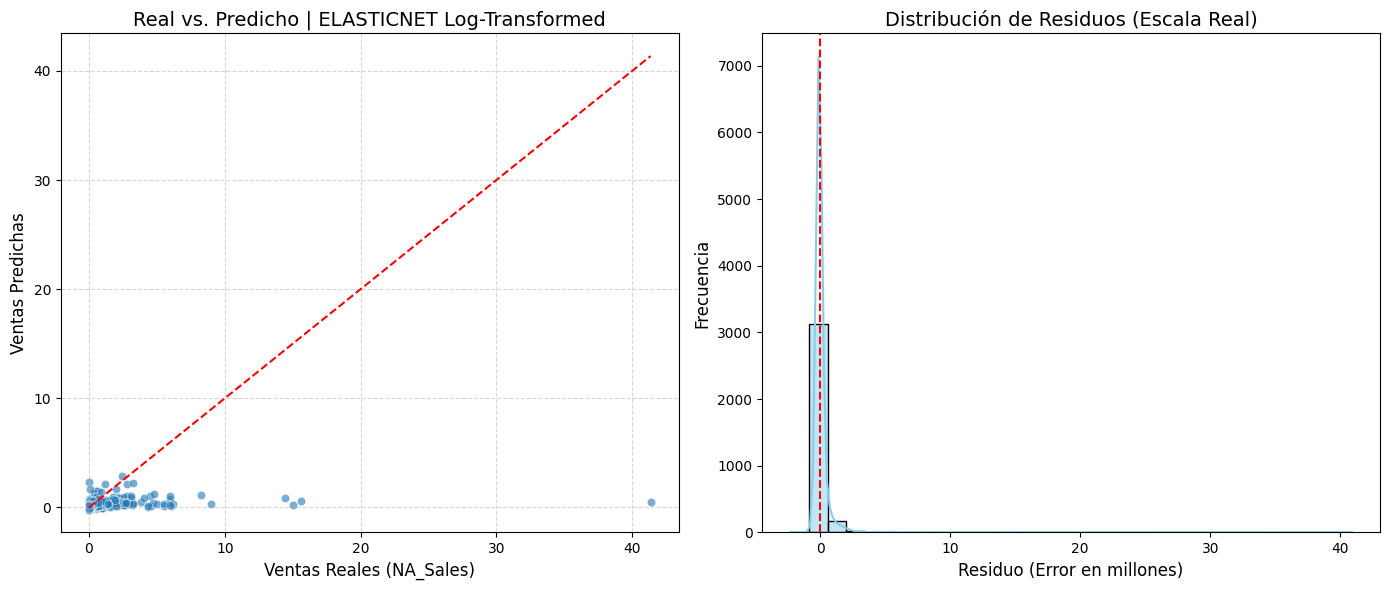

--- Iniciando GridSearch (LINEAR - LOG SCALE) para: NA_Sales ---
Ejecutando GridSearch para LINEAR con Target Logarítmico...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados: {'regressor__regressor__fit_intercept': True}
Mejor R2 (CV media): 0.1557
R2 Score en Test Set (Ventas Reales): 0.0704
MAE en Test Set (Ventas Reales): 0.2536


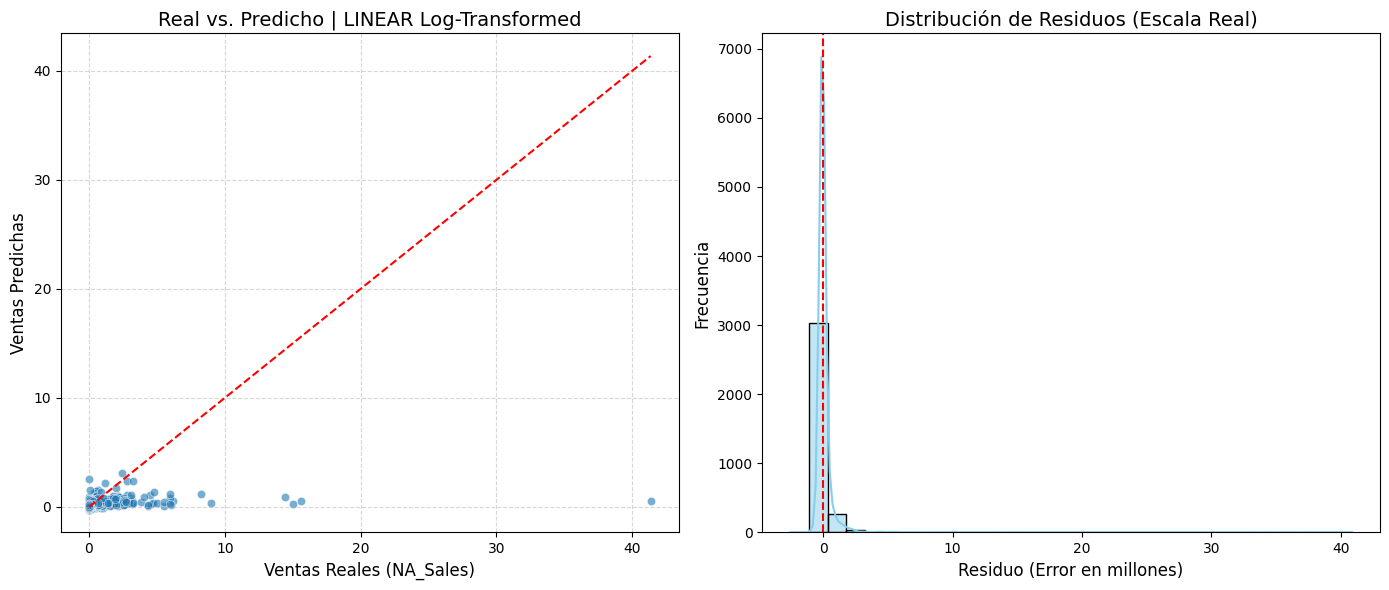

Resultats per: EU_Sales
--- Iniciando GridSearch (ELASTICNET - LOG SCALE) para: EU_Sales ---
Ejecutando GridSearch para ELASTICNET con Target Logarítmico...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros encontrados: {'regressor__regressor__alpha': 0.01, 'regressor__regressor__l1_ratio': 0.1}
Mejor R2 (CV media): 0.1388
R2 Score en Test Set (Ventas Reales): 0.0498
MAE en Test Set (Ventas Reales): 0.1631


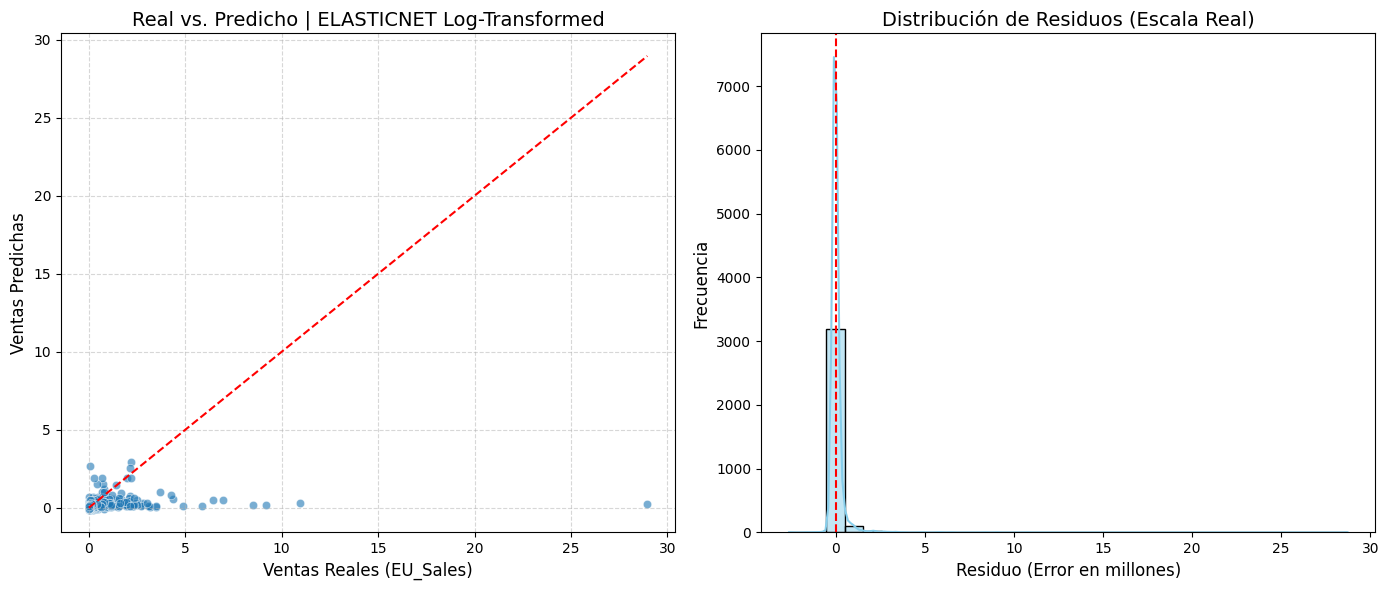

--- Iniciando GridSearch (LINEAR - LOG SCALE) para: EU_Sales ---
Ejecutando GridSearch para LINEAR con Target Logarítmico...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados: {'regressor__regressor__fit_intercept': True}
Mejor R2 (CV media): 0.1530
R2 Score en Test Set (Ventas Reales): 0.0555
MAE en Test Set (Ventas Reales): 0.1611


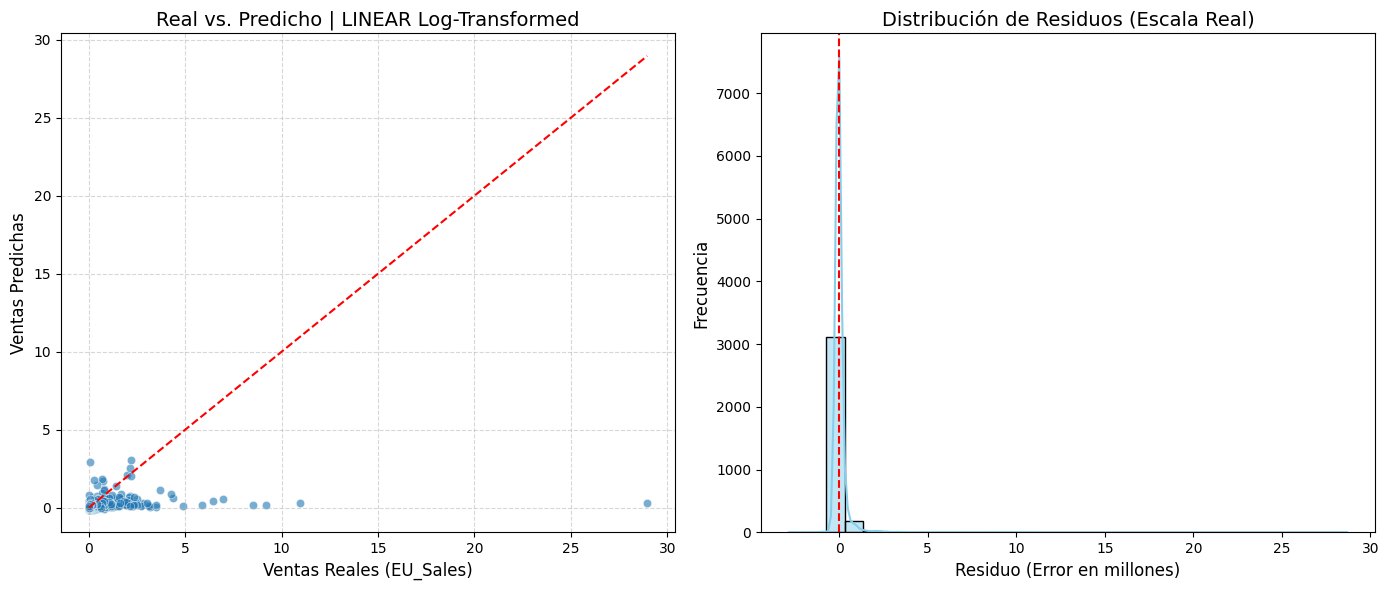

Resultats per: JP_Sales
--- Iniciando GridSearch (ELASTICNET - LOG SCALE) para: JP_Sales ---
Ejecutando GridSearch para ELASTICNET con Target Logarítmico...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros encontrados: {'regressor__regressor__alpha': 0.01, 'regressor__regressor__l1_ratio': 0.1}
Mejor R2 (CV media): 0.1045
R2 Score en Test Set (Ventas Reales): 0.0994
MAE en Test Set (Ventas Reales): 0.0966


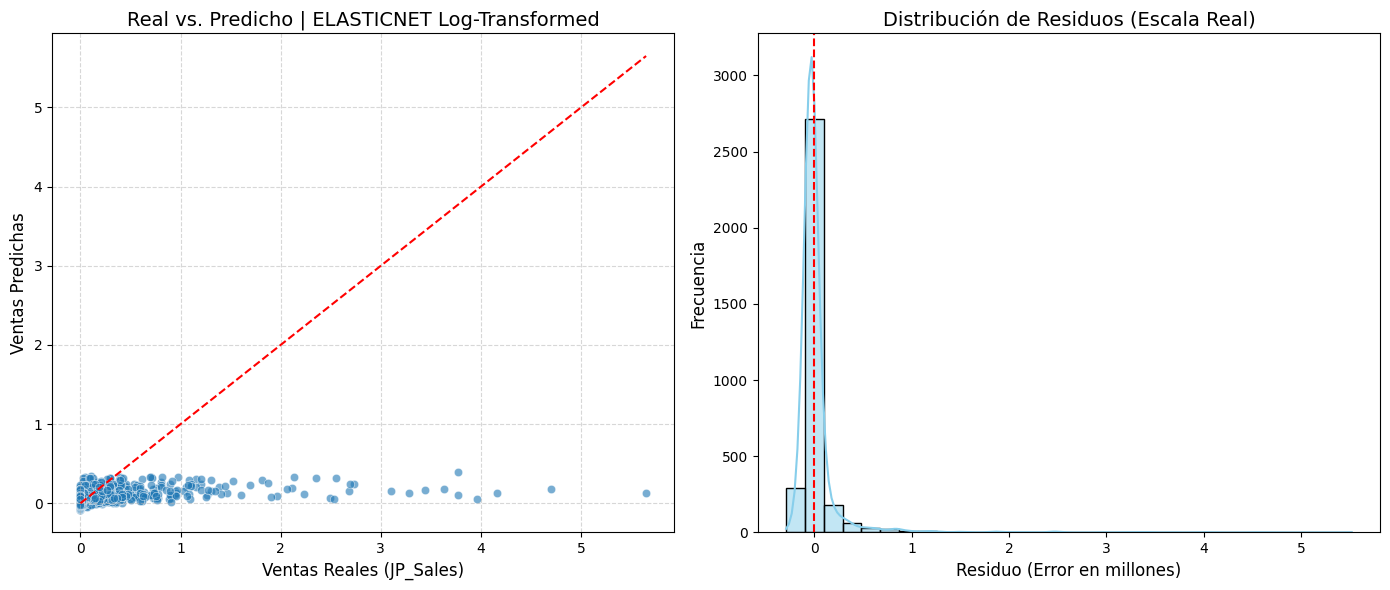

--- Iniciando GridSearch (LINEAR - LOG SCALE) para: JP_Sales ---
Ejecutando GridSearch para LINEAR con Target Logarítmico...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados: {'regressor__regressor__fit_intercept': True}
Mejor R2 (CV media): 0.1714
R2 Score en Test Set (Ventas Reales): 0.1575
MAE en Test Set (Ventas Reales): 0.0920


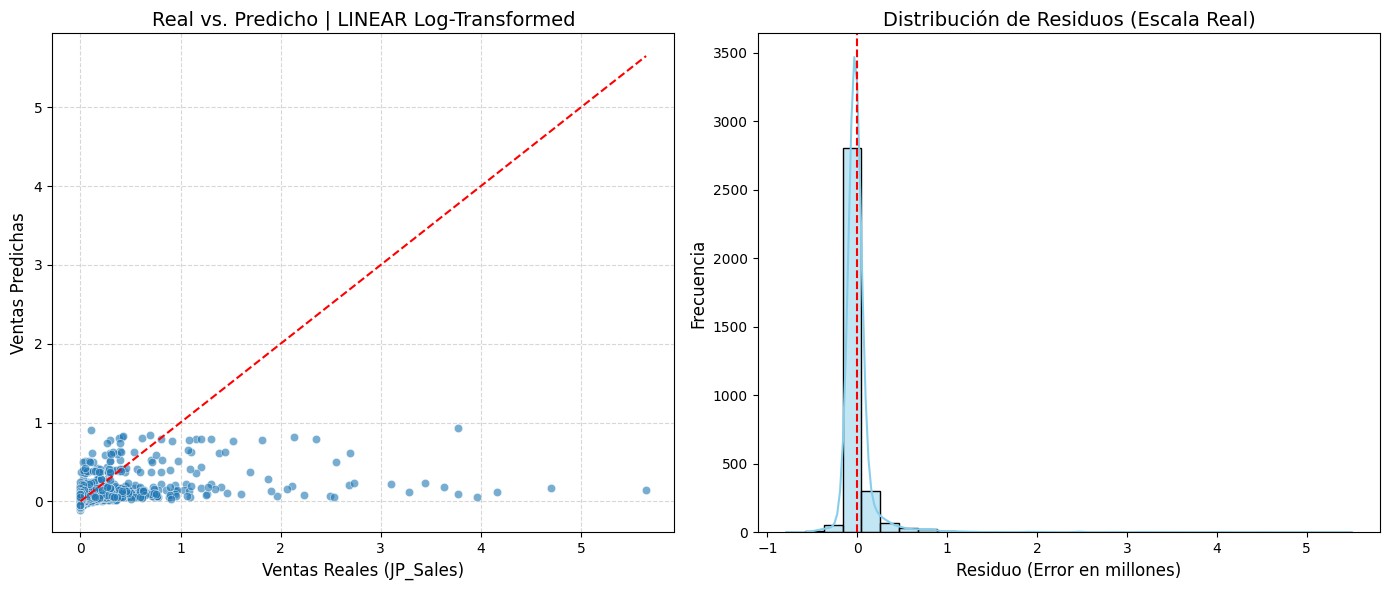

Resultats per: Other_Sales
--- Iniciando GridSearch (ELASTICNET - LOG SCALE) para: Other_Sales ---
Ejecutando GridSearch para ELASTICNET con Target Logarítmico...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros encontrados: {'regressor__regressor__alpha': 0.01, 'regressor__regressor__l1_ratio': 0.1}
Mejor R2 (CV media): 0.1170
R2 Score en Test Set (Ventas Reales): 0.0789
MAE en Test Set (Ventas Reales): 0.0535


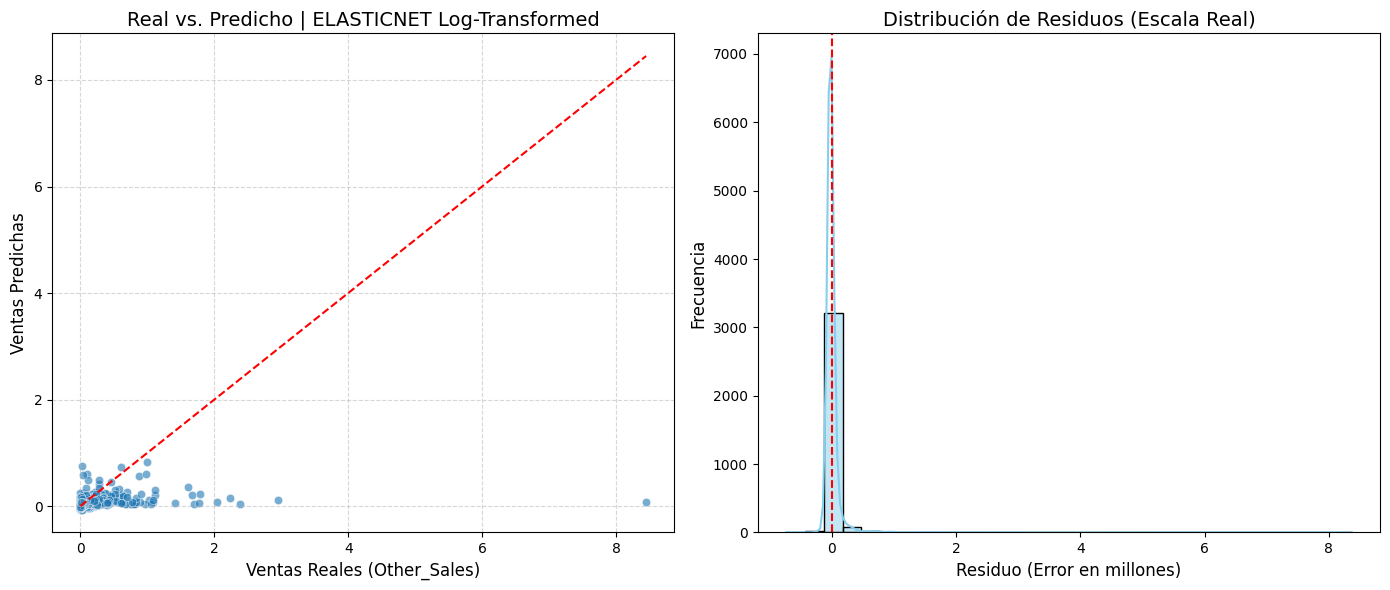

--- Iniciando GridSearch (LINEAR - LOG SCALE) para: Other_Sales ---
Ejecutando GridSearch para LINEAR con Target Logarítmico...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados: {'regressor__regressor__fit_intercept': True}
Mejor R2 (CV media): 0.1351
R2 Score en Test Set (Ventas Reales): 0.0918
MAE en Test Set (Ventas Reales): 0.0529


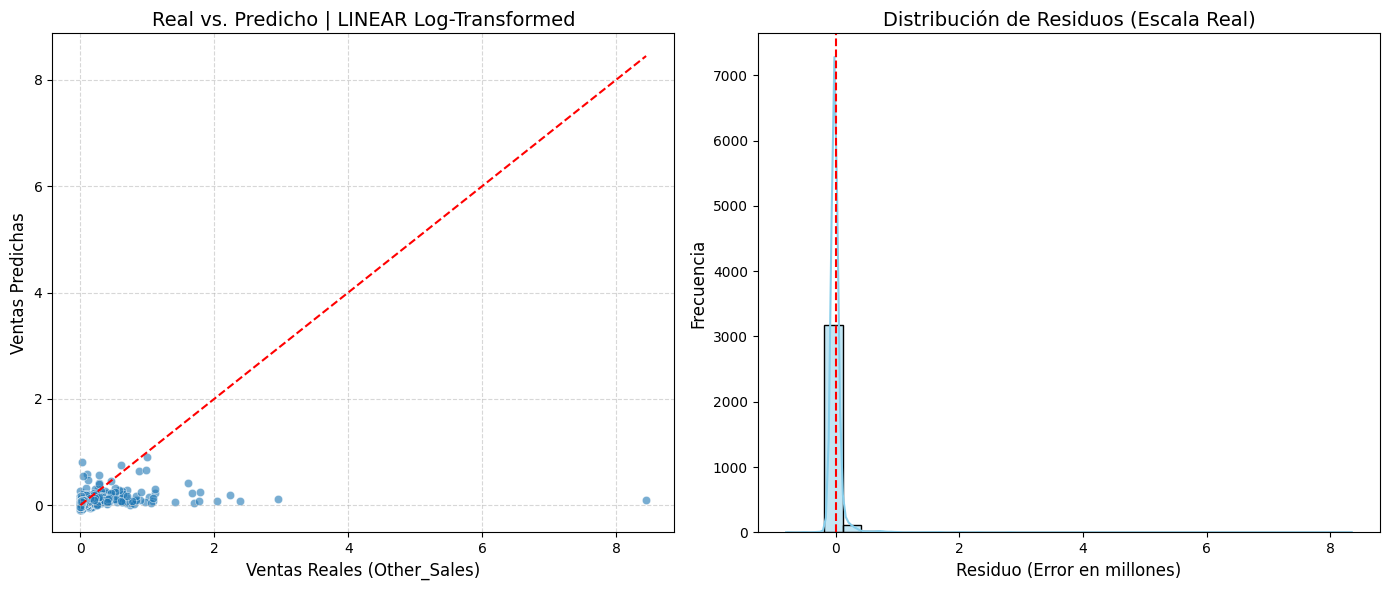

Resultats per: Global_Sales
--- Iniciando GridSearch (ELASTICNET - LOG SCALE) para: Global_Sales ---
Ejecutando GridSearch para ELASTICNET con Target Logarítmico...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros encontrados: {'regressor__regressor__alpha': 0.01, 'regressor__regressor__l1_ratio': 0.1}
Mejor R2 (CV media): 0.1393
R2 Score en Test Set (Ventas Reales): 0.0577
MAE en Test Set (Ventas Reales): 0.4710


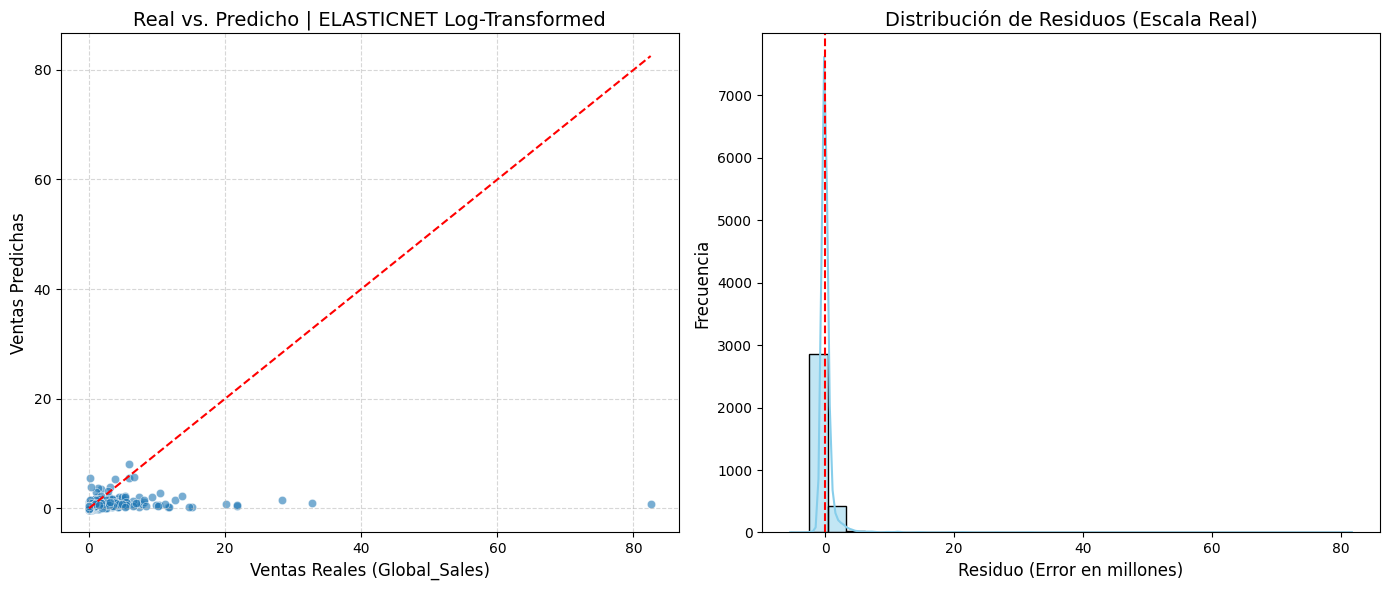

--- Iniciando GridSearch (LINEAR - LOG SCALE) para: Global_Sales ---
Ejecutando GridSearch para LINEAR con Target Logarítmico...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados: {'regressor__regressor__fit_intercept': True}
Mejor R2 (CV media): 0.1562
R2 Score en Test Set (Ventas Reales): 0.0630
MAE en Test Set (Ventas Reales): 0.4679


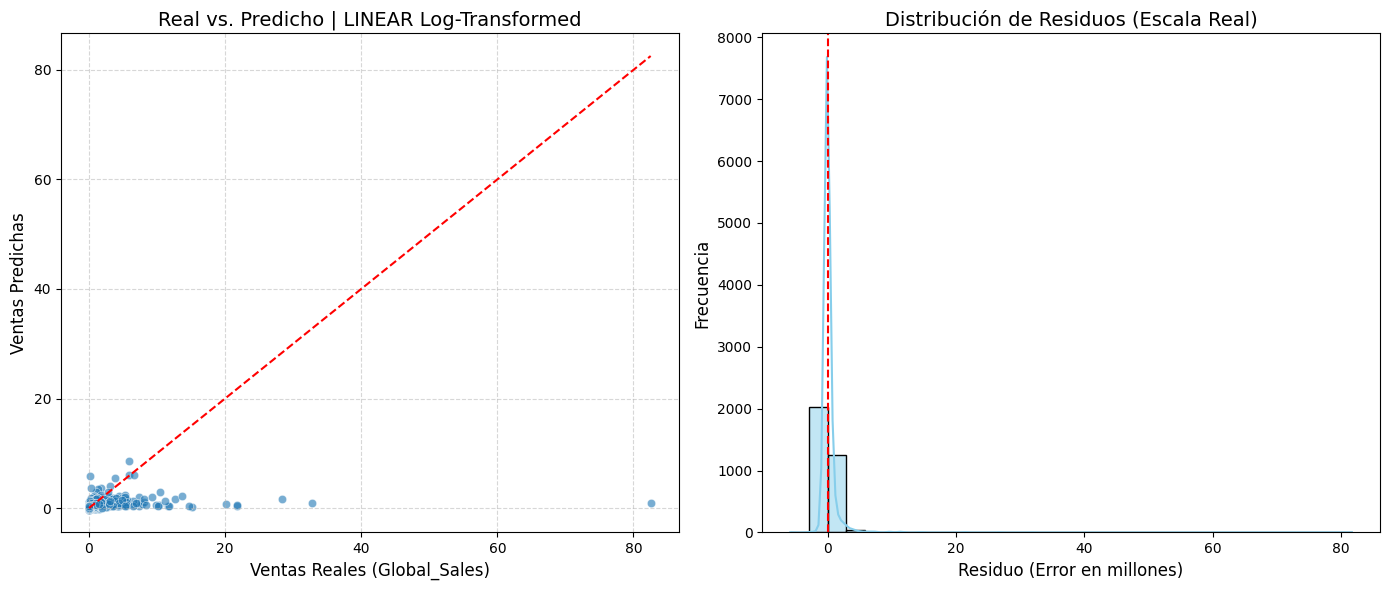

In [67]:
targets = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

for t in targets:
    print("Resultats per: " + t)

    # 1. Regressió Elàstica (NOU)
    model_elastic = entrenar_modelos_lineales(df, target_col=t, modelo_lineal_tipo='elasticnet')

    # 2. Regressió Lineal Pura
    model_linear = entrenar_modelos_lineales(df, target_col=t, modelo_lineal_tipo='linear')

---
## Anàlisis final
